# Create MURA training, validation, and test sets
The purpose of this notebook is to create an encoded MNIST dataset and split it in training, validation, and testing

In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import torchvision.transforms as transforms
from torchvision import datasets
import torch

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [33]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [3]:
%%time
# Compute MURA encoder and decoder
p = 23 # size of array (has to be prime)
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

CPU times: user 1.92 ms, sys: 52 µs, total: 1.97 ms
Wall time: 1.96 ms


Text(0.5, 1.0, 'Decoder')

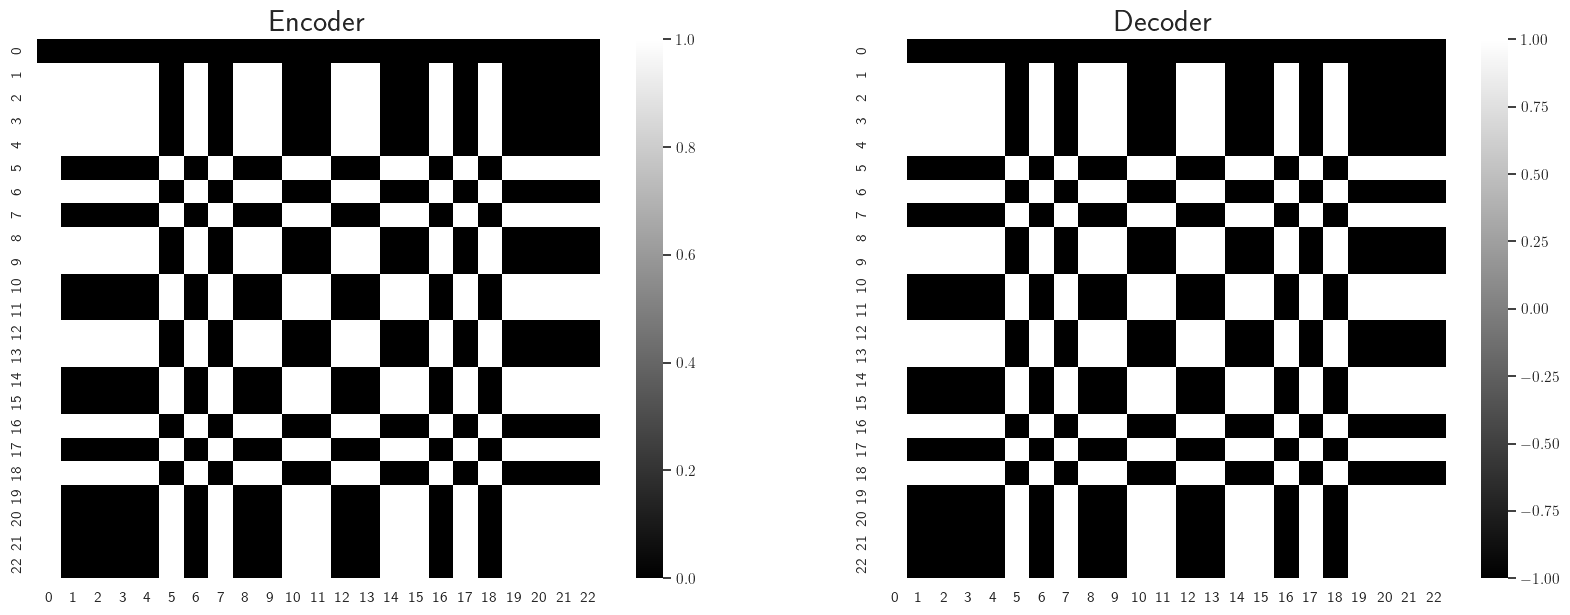

In [68]:
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs = axs.ravel()

sns.heatmap(A, cmap='gray', ax=axs[0])
axs[0].set_title("Encoder", fontsize=22)

sns.heatmap(G, cmap='gray', ax=axs[1])
axs[1].set_title("Decoder", fontsize=22)

In [4]:
# Load MNIST data from PyTorch and
    # (1) Convert to tensor
    # (2) Resize from 28x28 to pxp 
    # (3) Normalize entries between [0,1]
train_data = datasets.MNIST(
    root = '../data/',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(p),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)

test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(p),
                    transforms.Normalize(0, 1)
                ]) 
)

## Transform MNIST data
MNIST is only saved as training and testing datasets. We want to separate the data into training, validation, and testing.  
For this, I will do the following split: 80% training, 10% validation, and 10% testing. To get these quantities in code, I will have to hardcode some numbers. 

In [5]:
%%time

# Transform the the whole dataset into a list by concatenating training and testing
all_data_list   = list(train_data) + list(test_data)
print(f'Length of whole dataset is {len(all_data_list)}.')


# ------------------ Create new set of training, validation, and testing 
# Define list to save encoded image and original image data
mura_all_data = []

for idx in range(len(all_data_list)):
    img_label_list = list(all_data_list[idx])
    
    # Data will be saved as a tuple of (encoded image, original image, number) where we will use original image as labels
    # For the encoded image, do FFT convolve and then normalize images
    img_label_list[0] = torch.unsqueeze(torch.tensor(mura.normalize(mura.FFT_convolve(np.squeeze(all_data_list[idx][0].numpy()), A,p)), dtype= torch.float), 0)
    img_label_list[1] = all_data_list[idx][0]
    img_label_list.append(all_data_list[idx][1])
    mura_all_data.append(tuple(img_label_list))
    
print(f'Done! Length of encoded data list is : {len(mura_all_data)}')

70000


In [23]:
# Separate into training, validation and testing
# Splits of 80, 10, and 10 percent of 70000
mura_train_data = mura_all_data[:int(len(mura_all_data)*0.8)]
mura_eval_data  = mura_all_data[int(len(mura_all_data)*0.8):int(len(mura_all_data)*0.9)]
mura_test_data  = mura_all_data[int(len(mura_all_data)*0.9):] 

print(f"Number of elements in each dataset \nTraining: {len(mura_train_data)} \nValidation: {len(mura_eval_data)} \nTesting: {len(mura_test_data)}")

Number of elements in each dataset 
Training: 56000 
Validation: 7000 
Testing: 7000


## Make sure each set is well balanced

In [37]:
# Save lists of just the digits in each set
all_digits = [mura_all_data[i][2] for i in range(len(mura_all_data))]
train_digits = [mura_train_data[i][2] for i in range(len(mura_train_data))]
eval_digits  = [mura_eval_data[i][2] for i in range(len(mura_eval_data))]
test_digits  = [mura_test_data[i][2] for i in range(len(mura_test_data))]

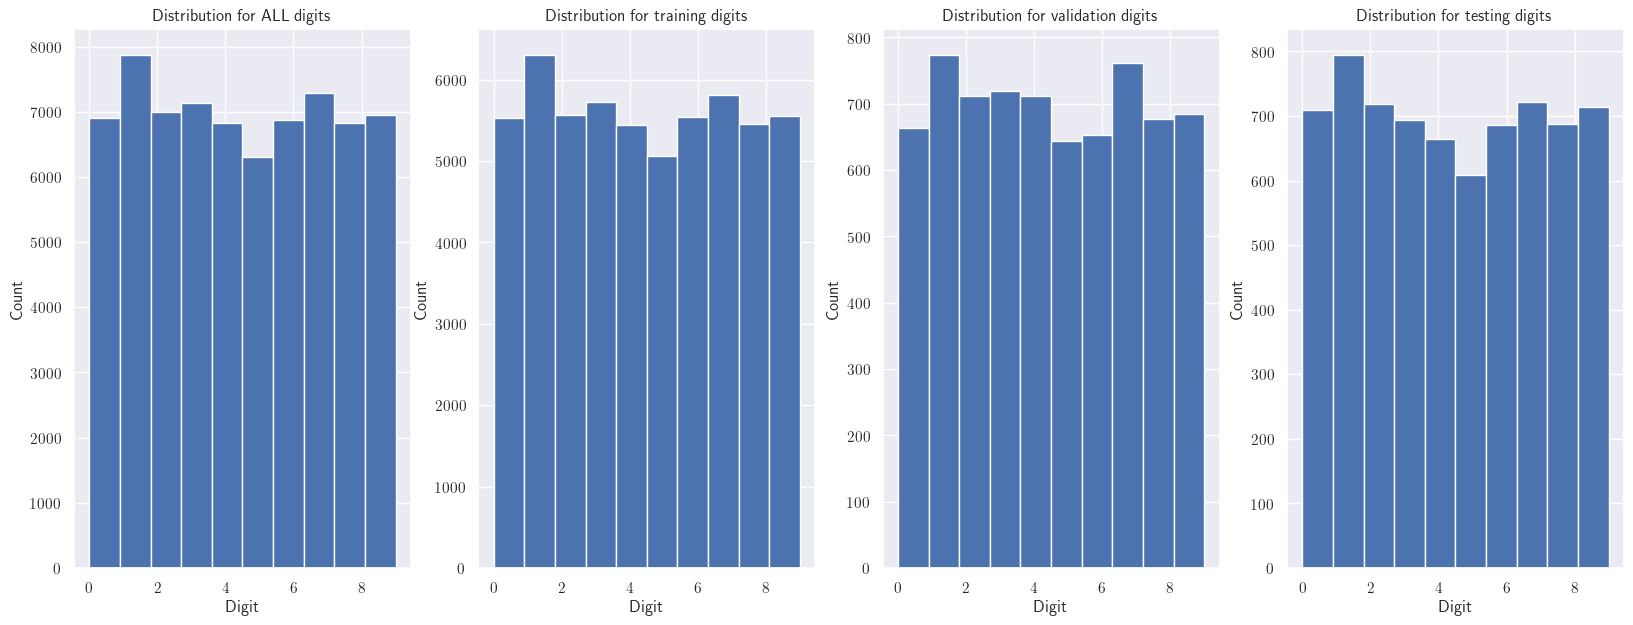

In [54]:
fig, axs = plt.subplots(1,4, figsize=(20,7))
axs = axs.ravel()
axs[0].hist(all_digits)
axs[0].set_title("Distribution for ALL digits")

axs[1].hist(train_digits)
axs[1].set_title("Distribution for training digits")

axs[2].hist(eval_digits)
axs[2].set_title("Distribution for validation digits")

axs[3].hist(test_digits)
axs[3].set_title("Distribution for testing digits")

for i in range(4):
    axs[i].set_xlabel("Digit")
    axs[i].set_ylabel("Count")
plt.show()

# Save Data

In [56]:
filename_train = "../data/training_MNIST_mura"
filename_eval = "../data/validation_MNIST_mura"
filename_test = "../data/testing_MNIST_mura"

In [59]:
%%time

# Save encoded data 
torch.save(mura_train_data, filename_train)
torch.save(mura_eval_data, filename_eval)
torch.save(mura_test_data, filename_test)

CPU times: user 4.39 s, sys: 1.68 s, total: 6.07 s
Wall time: 6.6 s
